# Analysis of Processed and Filtered Data

**Imports**

In [168]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from disaster_extr_constants import *
from disaster_extr_helpers import df_time_interval

In [159]:
def extract_disaster(year,disaster_type):
    if year == 2018 and disaster_type == 'storm':
        disaster_path_asia = 'data/'+str(year)+'_'+disaster_type+'_filtered_asia_csv.bz2'
        disaster_path_america = 'data/'+str(year)+'_'+disaster_type+'_filtered_america_csv.bz2'
        
        disaster_df = pd.read_csv(disaster_path_asia, parse_dates = ['date'], compression='bz2')
        disaster_df_2 = pd.read_csv(disaster_path_america, parse_dates = ['date'], compression='bz2')

    else:
        disaster_path = 'data/'+str(year)+'_'+disaster_type+'_filtered_csv.bz2'
        disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
        disaster_df_2 = None
        
    climate_path = 'data/'+str(year)+'_'+disaster_type+'_climate_filtered_csv.bz2'
    climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')
    
    start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
    if year == 2018 and disaster_type == 'storm':
        start_disaster_2, end_disaster_2 = disaster_df_2.date.min(), disaster_df_2.date.max()
        
        start_disaster = min([start_disaster,start_disaster_2])
        end_disaster = min([end_disaster,end_disaster_2])
    
    start_climate, end_climate = climate_df.date.min(), climate_df.date.max()
    
    return (climate_df, start_climate, end_climate), (disaster_df, start_disaster, end_disaster), disaster_df_2

In [160]:
def create_plot_comparison(year,disaster_type):
        
    all_data = extract_disaster(year,disaster_type)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    if disaster_df_2:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    
    _, bins, _ = plt.hist(
        climate_df.date, 
        bins=60, 
        weights=climate_df.numOccurrences,
        alpha=0.4,
        label='Climate Talk', 
        log=True)
    
    plt.hist(
        disaster_df.date, 
        bins=bins, 
        weights=disaster_df.numOccurrences,
        alpha=0.7,
        label=type_to_str[disaster_type]+dscr_str+' Talk')
    
    if disaster_df_2:
        plt.hist(
            disaster_df_2.date, 
            bins=bins, 
            weights=disaster_df_2.numOccurrences,
            alpha=0.3,
            label=type_to_str[disaster_type]+dscr_str_2+' Talk')
    
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [161]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-05-20 --- 2015-06-09
Climate Dates:  2015-04-29 --- 2015-06-20


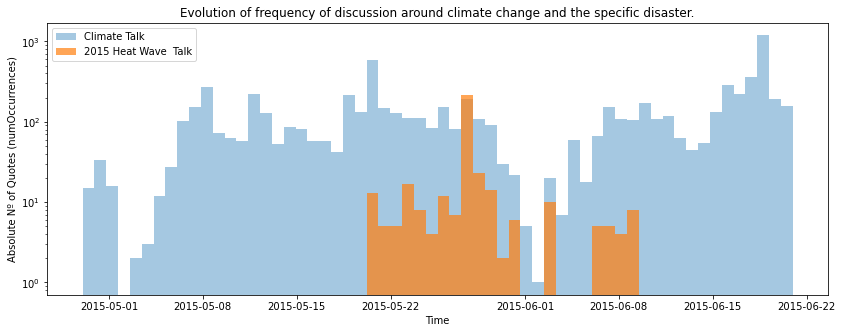

In [162]:
create_plot_comparison(2015,disaster_type)

Disaster Dates: 2016-04-17 --- 2016-05-20
Climate Dates:  2016-03-11 --- 2016-05-20


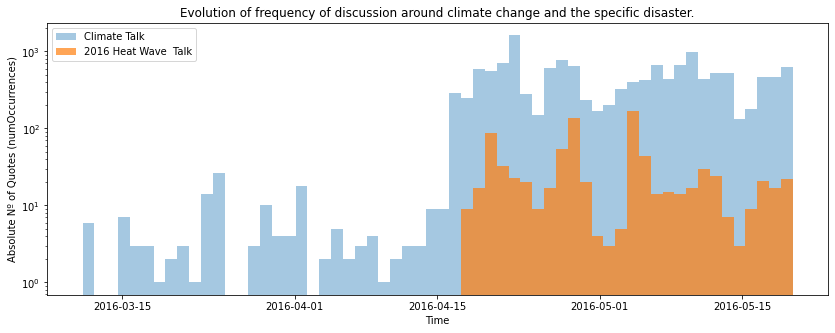

In [155]:
create_plot_comparison(2016,disaster_type)

Disaster Dates: 2017-01-31 --- 2017-02-24
Climate Dates:  2017-01-11 --- 2017-03-07


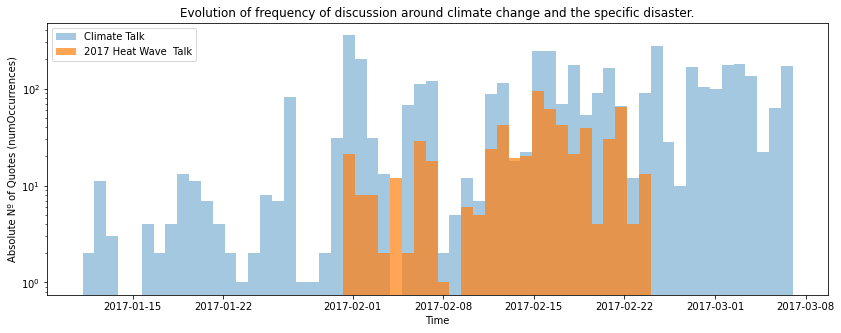

In [156]:
create_plot_comparison(2017,disaster_type)

Disaster Dates: 2018-07-01 --- 2018-08-03
Climate Dates:  2018-06-10 --- 2018-08-03


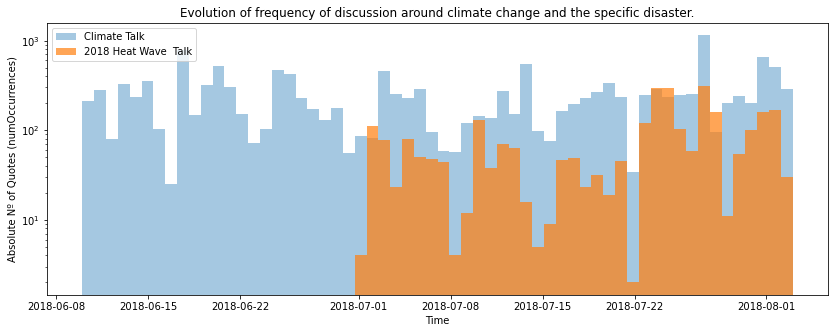

In [157]:
create_plot_comparison(2018,disaster_type)

Disaster Dates: 2019-07-19 --- 2019-08-05
Climate Dates:  2019-06-28 --- 2019-08-17


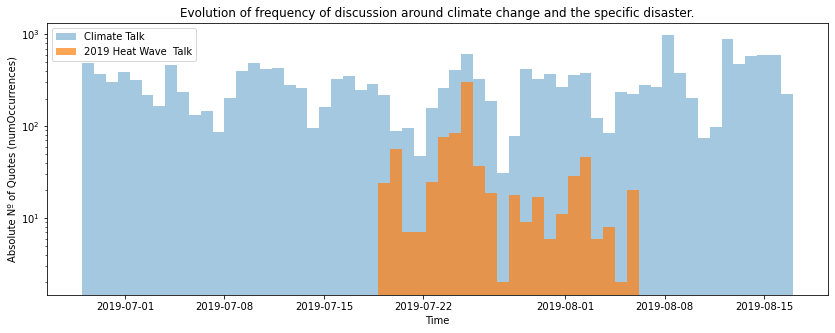

In [158]:
create_plot_comparison(2019,disaster_type)

Disaster Dates: 2019-09-02 --- 2020-01-31
Climate Dates:  2019-08-11 --- 2020-02-01


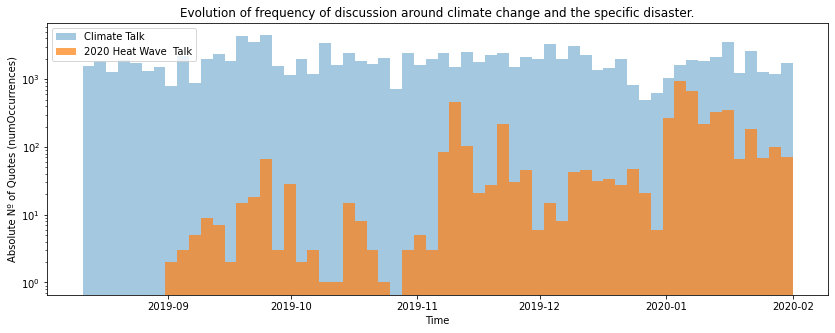

In [135]:
create_plot_comparison(2020,disaster_type)

In [136]:
disaster_type = 'storm'

Disaster Dates: 2015-10-22 --- 2015-11-06
Climate Dates:  2015-10-01 --- 2015-11-18


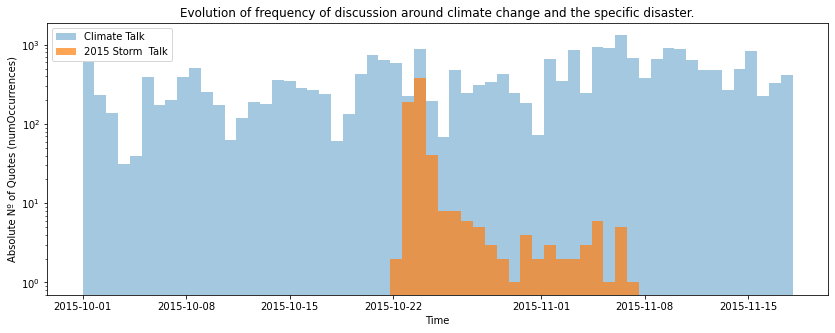

In [137]:
create_plot_comparison(2015,disaster_type)

Disaster Dates: 2016-02-18 --- 2016-02-26
Climate Dates:  2016-01-30 --- 2016-03-11


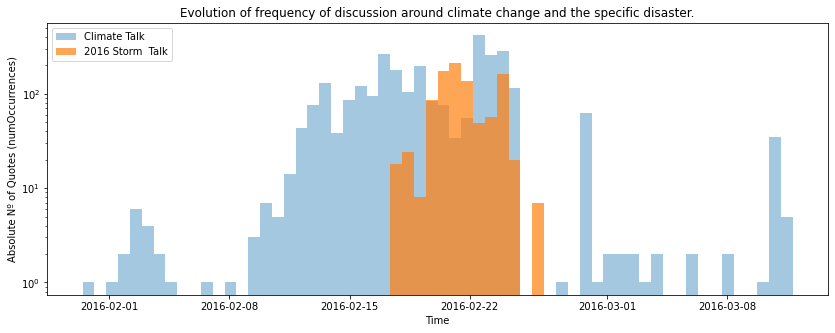

In [138]:
create_plot_comparison(2016,disaster_type)

Disaster Dates: 2017-08-23 --- 2017-09-08
Climate Dates:  2017-08-04 --- 2017-09-19


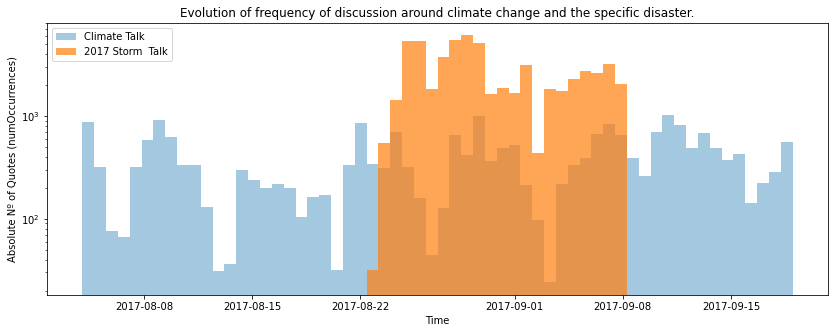

In [139]:
create_plot_comparison(2017,disaster_type)

Disaster Dates: 2018-09-08 --- 2018-09-27
Climate Dates:  2018-08-20 --- 2018-10-09


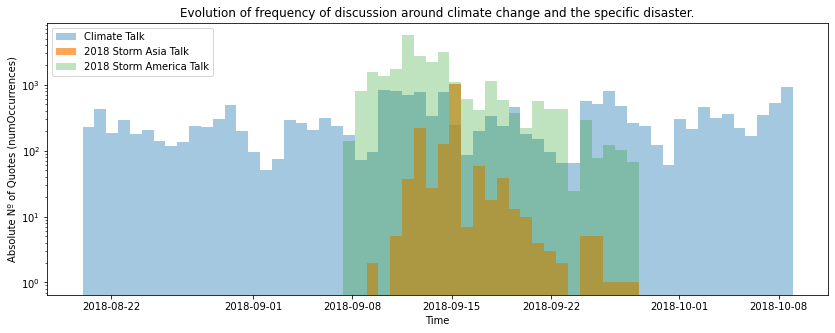

In [140]:
create_plot_comparison(2018,disaster_type)

Disaster Dates: 2019-10-07 --- 2019-10-27
Climate Dates:  2019-09-21 --- 2019-11-07


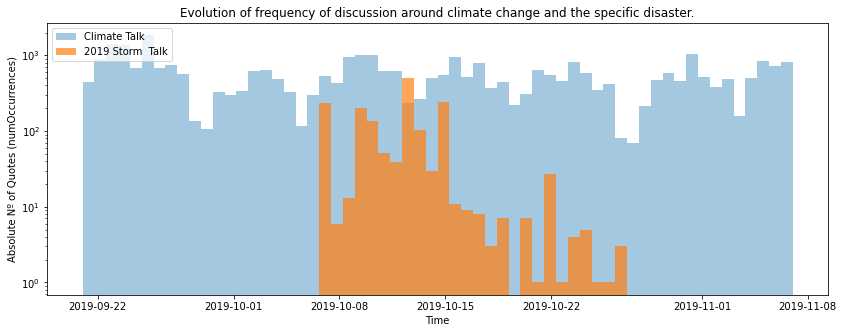

In [141]:
create_plot_comparison(2019,disaster_type)

Disaster Dates: 2019-12-02 --- 2019-12-12
Climate Dates:  2019-11-11 --- 2019-12-24


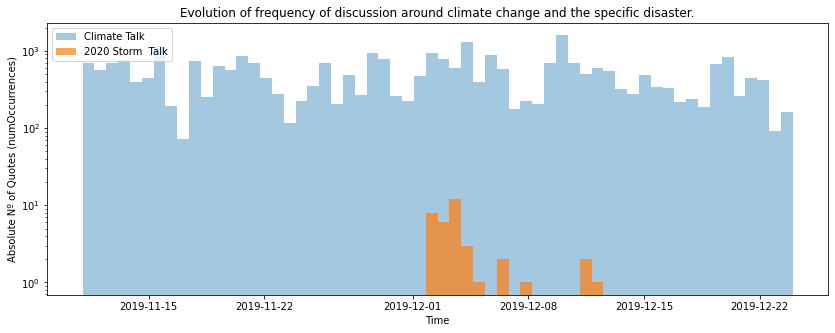

In [142]:
create_plot_comparison(2020,disaster_type)

In [164]:
all_data = extract_disaster(year=2017,disaster_type='heat_wave')

(climate_df, start_climate, end_climate) = all_data[0]
(disaster_df, start_disaster, end_disaster) = all_data[1]
disaster_df_2 = all_data[2]

In [195]:
climate_df_sampled = climate_df.set_index('date').resample('2D').sum().dropna().reset_index()

In [196]:
disaster_df_sampled = disaster_df.set_index('date').resample('2D').sum().dropna().reset_index()

In [169]:
climate_limited = df_time_interval(climate_df, start_disaster, end_disaster, date_attr='date')

<AxesSubplot:xlabel='date'>

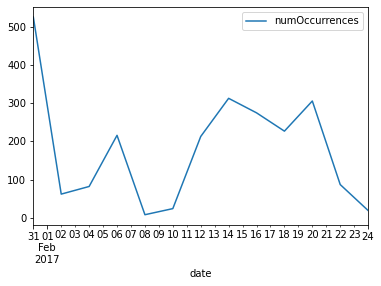

In [191]:
climate_limited.set_index('date').resample('2D').sum().dropna().reset_index().plot(x='date', y='numOccurrences')

<AxesSubplot:xlabel='date'>

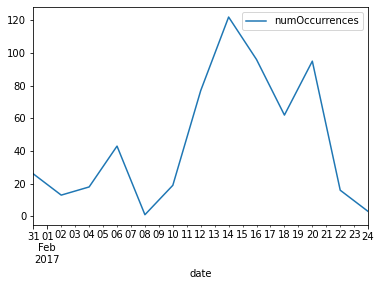

In [194]:
disaster_df.set_index('date').resample('2D').sum().dropna().reset_index().plot(x='date', y='numOccurrences')

In [175]:
climate_limited.set_index('date').resample('2D').sum().dropna().reset_index()

,date,numOccurrences
0,2017-01-31,526
1,2017-02-02,62
2,2017-02-04,82
3,2017-02-06,216
4,2017-02-08,8
5,2017-02-10,24
6,2017-02-12,213
7,2017-02-14,313
8,2017-02-16,275
9,2017-02-18,227


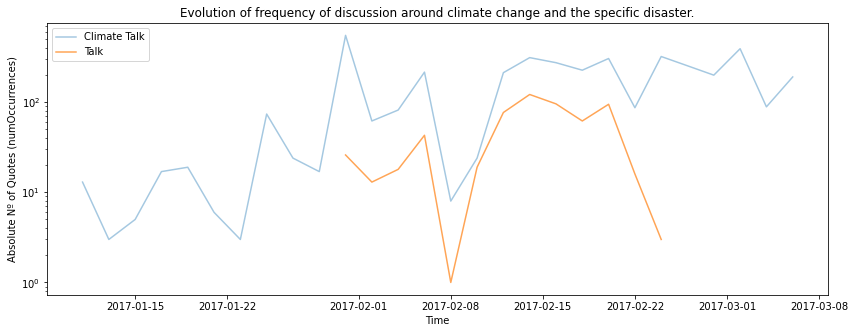

In [197]:
fig = plt.gcf()
fig.set_size_inches(14, 5)

plt.plot(
    climate_df_sampled.date,  
    climate_df_sampled.numOccurrences,
    alpha=0.4,
    label='Climate Talk')
    
plt.plot(
    disaster_df_sampled.date,  
    disaster_df_sampled.numOccurrences,
    alpha=0.7,
    label='Talk')

plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
plt.legend(loc='upper left')
plt.show()